# Importing libraries

In [ ]:
import re
import nltk
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')

In [2]:
# Load Tweet dataset
import pandas as pd
df = pd.read_pickle(r'./all_sentiment_data_3_24.pkl')
df.head()

,text,label,clean_list_words
0,Just got back from seeing @GaryDelaney in Burs...,joy,"[got, back, see, garydelaney, burslem, amaz, f..."
1,Oh dear an evening of absolute hilarity I don'...,joy,"[oh, dear, even, absolut, hilar, think, laugh,..."
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,"[wait, week, game, cheer, friday]"
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,"[gardin, love, thank, much, gloria, sweet, tho..."
4,I feel so blessed to work with the family that...,joy,"[feel, bless, work, famili, nanni, noth, love,..."


# Assessing

## Train dataset

In [4]:
#check if the data is balanced or not
df.label.value_counts()

fear         2252
happiness    1814
anger        1701
joy          1616
sadness      1533
love         1514
Name: label, dtype: int64

In [5]:
#check if the data is balanced or not
df.label.value_counts() / df.shape[0] *100

fear         21.591563
happiness    17.392138
anger        16.308725
joy          15.493768
sadness      14.697987
love         14.515820
Name: label, dtype: float64

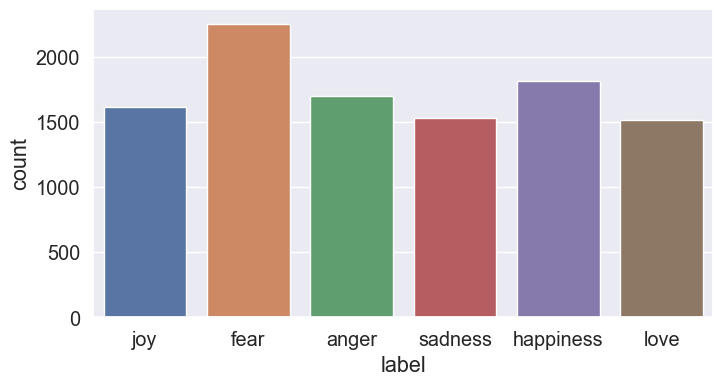

In [6]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df);

The data is balanced

In [7]:
#print the number of null values in each column
boolean = df.duplicated(subset=['text']).any() # True
print(df.shape)
boolean 

(10430, 4)


True

The data contains any null values

In [8]:
#print the number of duplicated values 
df.drop_duplicates(subset=['text'], inplace=True)
print(df.shape)

(10236, 4)


In [9]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

In [10]:
#dataframe_difference(df_train, df_test, which='both')

In [11]:
#dataframe_difference(df_train, df_val, which='both')

In [12]:
#dataframe_difference(df_val, df_test, which='both')

## Cleaning

## Modeling

### TF-IDF
The word counts suffer some issues: most frequent words are usually not important (like stop words), while they take high focus/count.

TFIDF (Term Frequency - Inverse Document) is a way to adjust those counts:

TF: #mentions within a document

IDF: #mentions across all docs 

So it gives higher importance to rare words across all docs (IDF++, TFIDF--), while it emphasyses on words appearing mostly in THIS doc (TF++, TFIDF--).

If a word appearing only in the current doc/sentence, it has TFIDF=1. If a word appears in all docs/sents but not the current one, it has TFIDF=0. If a word (stop word for example) appearing a lot in the current doc/sent and also in ALL others, it will have high TF (count) and much higher IDF (discount), so low TFIDF overall.

We will start by baseline models

**Creating a pipline using tf-idf for words embedding and different models.**


In [13]:
df.head()

,text,label,clean_list_words,clean_words
0,Just got back from seeing @GaryDelaney in Burs...,joy,"[got, back, see, garydelaney, burslem, amaz, f...",got back seeing garydelaney burslem amazing fa...
1,Oh dear an evening of absolute hilarity I don'...,joy,"[oh, dear, even, absolut, hilar, think, laugh,...",oh dear evening absolute hilarity think laughe...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,"[wait, week, game, cheer, friday]",waiting week game ❤️❤️❤️ cheer friday ❤️
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,"[gardin, love, thank, much, gloria, sweet, tho...",gardiner love thank much gloria sweet thoughtf...
4,I feel so blessed to work with the family that...,joy,"[feel, bless, work, famili, nanni, noth, love,...",feel blessed work family nanny ❤️ nothing love...


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_words'].values, df['label'].values, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(df['clean_words'], df['label'].values, test_size=0.15, random_state=1)

In [15]:
def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

In [16]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [17]:
#print the labels after encoding 
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [18]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [19]:
print(y_train)

[[0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


## Tokenizing

In [20]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(df["clean_words"])

In [21]:
#document count: A dictionary of words and how many documents each appeared in.
#in this dataset the output will be the number of rows
tokenizer.document_count

10236

In [22]:
#word docs: An integer count of the total number of documents(or rows) that were used to fit the Tokenizer.
tokenizer.word_docs

defaultdict(int,
            {'face': 62,
             'amazing': 151,
             'got': 285,
             'seeing': 43,
             'hilarious': 92,
             'still': 222,
             'hurt': 35,
             'garydelaney': 2,
             'laughing': 29,
             'burslem': 2,
             'much': 242,
             'back': 230,
             'laughed': 8,
             'absolute': 10,
             'hilarity': 36,
             'dear': 25,
             'long': 98,
             '😂': 56,
             'evening': 35,
             'time': 386,
             'think': 250,
             'oh': 162,
             'game': 100,
             'week': 141,
             'friday': 41,
             'waiting': 27,
             'cheer': 55,
             '❤️': 11,
             '❤️❤️❤️': 1,
             'thoughtful': 4,
             'love': 632,
             'made': 115,
             'gloria': 1,
             'thank': 137,
             'joyful': 37,
             '😊💕': 1,
             'gardiner': 1,


In [23]:
#print the index of a single word
tokenizer.word_index['evening']

464

In [24]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[0].split())

[[24],
 [37],
 [373],
 [4660],
 [4661],
 [72],
 [236],
 [39],
 [485],
 [579],
 [35],
 [139]]

In [25]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
#the sentence contains three words and the size of the vocabulary is 14325
tokenizer.texts_to_matrix(X_train[0].split()).shape

(12, 19674)

In [27]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

## Padding

The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len. 

In [28]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 19674


In [29]:
#before
sequences_train[0]

[2439, 732, 3576, 646, 299, 32, 140, 323, 545, 170]

## Word Embedding

**This code defines the following variables:**

**path_to_glove_file**: The file path to the GloVe word vectors file.

**num_tokens**: The size of the vocabulary. This is typically the number of unique words in the dataset.

**embedding_dim**: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.) depending on the size of the word vectors file that is being used.

**hits**: A counter for the number of words that are found in the embeddings_index dictionary.

**misses**: A counter for the number of words that are not found in the embeddings_index dictionary.

**embeddings_index**: A dictionary that will store the word vectors, with the words as keys and the word vectors as values.

In [1]:
# Read GloVE embeddings

path_to_glove_file = './token/token_word_dictionary/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

NameError: name 'vocabSize' is not defined

num_tokens: The size of the vocabulary. This is typically the number of unique words in the dataset.
Set up vocabulary: defined by tokenizer2

1. Embedding matrix with all zero values and then looping through the vocabulary  (num_tokens * embedding_dim)
2. assign word vectors to the corresponding rows of the embedding matrix.
3. Calculate hit and miss
-> hit: if the input word is found in the dictionary, hits increase
-> miss: the input word not found, loss increase

In [31]:
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Found 400000 word vectors.
Converted 11821 words (7852 misses)


## Modeling

**The model consists of several layers:**

1. An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in the input. The input length is set to the length of the input sequences, and the weights are initialized with an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, meaning that the weights of this layer will not be updated during training.

2. Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should return the full sequences of outputs or just the last output of each sequence.

3. A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units and uses the 'softmax' activation function, which means that it will output a probability distribution over the 6 classes.

In [32]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          3934800   
                                                                 
 bidirectional (Bidirectiona  (None, 229, 512)         935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 229, 256)         656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [33]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [ ]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=40,
                    callbacks=[callback]
                   )

Epoch 1/40
34/34 [==============================] - 65243s 1973s/step - loss: 1.9238 - accuracy: 0.2099 - val_loss: 1.6774 - val_accuracy: 0.2741
Epoch 2/40
34/34 [==============================] - 20624s 614s/step - loss: 1.6185 - accuracy: 0.2951 - val_loss: 1.5628 - val_accuracy: 0.3105
Epoch 3/40
34/34 [==============================] - 26677s 785s/step - loss: 1.4435 - accuracy: 0.3716 - val_loss: 1.4051 - val_accuracy: 0.4030
Epoch 4/40
34/34 [==============================] - 29998s 883s/step - loss: 1.3501 - accuracy: 0.4203 - val_loss: 1.2280 - val_accuracy: 0.4876
Epoch 5/40
21/34 [=================>............] - ETA: 4:19:15 - loss: 1.1547 - accuracy: 0.5307

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_val, y_val, verbose=1) 

In [ ]:
#print the overall loss and accuracy
model.evaluate(X_test, y_test, verbose=1) 

In [ ]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)

print(classification_report(le.transform(df_test['Emotion']), y_pred))

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**So, you may asking when I give a sentence to the model how the classification will done?**

1. First, the model will convert the words in the sentence into numerical representations, also known as word embeddings. These word embeddings capture the meaning of the words and their relationships to each other in a continuous vector space.

2. The word embeddings for each word in the sentence are then input to two separate LSTM models: one that processes the sequence forwards and one that processes it backwards. At each time step, each LSTM processes the current word embedding and the previous hidden state to produce a new hidden state. The hidden state at each time step is a combination of the previous hidden state and the current input, and it captures the information from all the previous time steps in the sequence.

3. After processing all the words in the sentence, the two LSTMs will have final hidden states that encode the meaning of the sentence from both the forwards and backwards directions. These final hidden states are then combined and used to make a prediction.

In [ ]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

In [ ]:
sentence= 'my old brother is dead'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

In [ ]:
sentence= 'Im feeling sad today'
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

In [ ]:
model.save('Emotion Recognition From English text.h5')